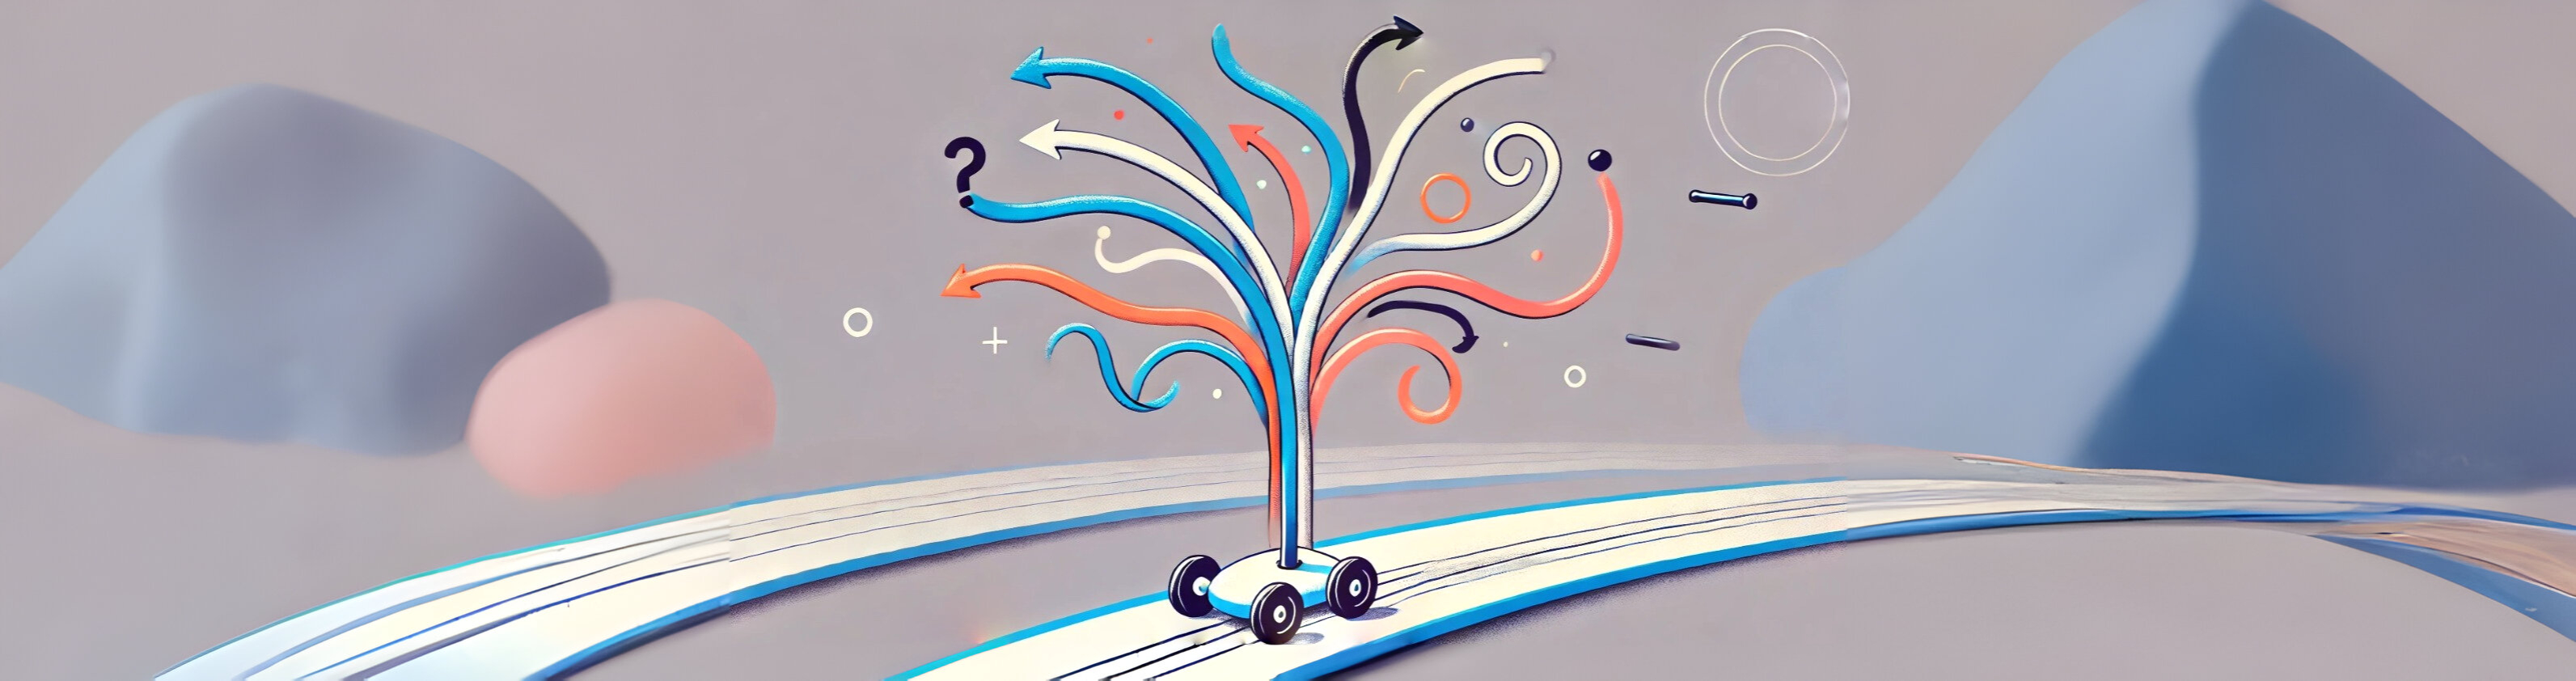

## Introduction

<a href="https://colab.research.google.com/github/khipu-ai/practicals-2025/blob/main/notebooks/Model_Predictive_Contol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will be learning about Model Predictive Control (MPC), an optimization-based control strategy that predicts and optimizes future actions to achieve optimal performance. Unlike Reinforcement Learning (RL), which learns through trial and error, MPC leverages a system model to make informed decisions at each step while respecting constraints.

MPC has been successfully applied in various domains, such as robotics, autonomous vehicles, and industrial process control.  In this tutorial, we will implement MPC to control a cartpole, optimizing actions to achieve stability and performance goals. Along the way, we will explore key concepts such as predictive sampling, trajectory optimization, and constraint handling.

## Setup

In [ ]:
# @title Install required packages (run me) { display-mode: "form" }
# @markdown This may take a minute or two to complete.
%%capture
!pip install mujoco
!pip install brax

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

from IPython.display import clear_output
clear_output()
from brax import base as brax_base
from brax.io import html
from brax.io import mjcf
from IPython.display import HTML
import jax
import matplotlib.pyplot as plt
from mujoco import mjx
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

import jax.numpy as jnp
from typing import Any, Callable, Tuple

from jax import numpy as jnp
from mujoco.mjx._src import dataclasses

### Copyright notice

Copyright 2024 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

## Simulation Environment - MuJoCo XLA (MJX)

MuJoCo XLA (MJX) is a high-performance physics simulator designed to integrate seamlessly with JAX, enabling accelerated computation and differentiation. Unlike OpenAI Gym, which provides a standardized interface for various reinforcement learning environments, MJX focuses on efficient simulation of continuous control problems with a differentiable physics engine. This allows for improved performance and direct gradient-based optimization, making it particularly useful for tasks requiring real-time simulation and control optimization.

In this tutorial, we will also be using the CartPole environment but in MJX. Remember that in CartPole the task is for the agent to learn to balance a pole for as long as possible by moving a cart left or right.

In [ ]:
#@title Mujoco task definition (run me) { display-mode: "form" }
#@markdown This cell initializes the MuJoCo simulation environment for cartpole, defining the system dynamics, state representations, and control actions using the Mujoco format.
%%capture
# task

CostFn = Callable[[mjx.Model, mjx.Data], jax.Array]

xml = """
<mujoco model="cart-pole">
  <option timestep="0.01" integrator="RK4">
    <flag contact="disable" energy="disable"/>
  </option>

  <default>
    <default class="pole">
      <joint type="hinge" axis="0 1 0"  damping="2e-6"/>
      <geom type="capsule" fromto="0 0 0 0 0 -1" size="0.045" mass=".1"/>
    </default>
  </default>

  <worldbody>
    <light name="light" pos="0 0 6"/>
    <camera name="fixed" pos="0 -4 1" zaxis="0 -1 0"/>
    <camera name="lookatcart" mode="targetbody" target="cart" pos="0 -2 2"/>
    <geom name="floor" pos="0 0 -.05" size="4 4 .2" type="plane"/>
    <geom name="rail1" type="capsule" pos="0  .07 1" zaxis="1 0 0" size="0.02 2"/>
    <geom name="rail2" type="capsule" pos="0 -.07 1" zaxis="1 0 0" size="0.02 2"/>
    <body name="cart" pos="0 0 1">
      <joint name="slider" type="slide" limited="true" axis="1 0 0" range="-1.8 1.8" solreflimit=".08 1" damping="5e-4"/>
      <geom name="cart" type="box" size="0.2 0.15 0.1" mass="1"/>
      <body name="pole_1" childclass="pole">
        <joint name="hinge_1"/>
        <geom name="pole_1"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="slide" joint="slider" gear="10" ctrllimited="true" ctrlrange="-1 1" />
  </actuator>
</mujoco>
"""
sim_model_cpu = mujoco.MjModel.from_xml_string(xml)
plan_model_cpu = mujoco.MjModel.from_xml_string(xml)

def set_state(d, state):
  return d.replace(
      time=state.time, qpos=state.qpos, qvel=state.qvel, act=state.act,
      ctrl=state.ctrl)

def cost_fn(model, data):
  cart_in_middle = data.qpos[..., 0]**2
  pole_is_up = jnp.cos(data.qpos[..., 1])
  return 0.1*cart_in_middle + pole_is_up

In [ ]:
#@title Run this to visualize the environment
duration = 3.0  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
times = []
costs = []
sim_data_cpu = mujoco.MjData(sim_model_cpu)
mujoco.mj_resetData(sim_model_cpu, sim_data_cpu)  # Reset state and time.
sim_data_cpu.ctrl[0] = -0.1
with mujoco.Renderer(sim_model_cpu) as renderer:
  while sim_data_cpu.time < duration:
    mujoco.mj_step(sim_model_cpu, sim_data_cpu)
    costs.append(cost_fn(sim_model_cpu, sim_data_cpu))
    times.append(sim_data_cpu.time)
    if len(frames) < sim_data_cpu.time * framerate:
      renderer.update_scene(sim_data_cpu)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)


## Model Predictive Control (MPC)

Model Predictive Control (MPC) is an optimization-based control strategy that uses a model of the system to predict and optimize future behavior. MPC explicitly considers constraints and optimizes a sequence of control actions over a finite time horizon. In contrast to pure Reinforcement Learning (RL), which learns policies from trial and error using rewards, MPC relies on a known system model to make informed decisions at each timestep. While RL can adapt to unknown dynamics, MPC ensures stability and constraint satisfaction by leveraging predictive optimization.

### How MPC Works
1. **Prediction:** Using a model of the system, MPC predicts the future behavior over a finite horizon.
2. **Optimization:** The control inputs are optimized to minimize a cost function while respecting constraints.
3. **Execution:** The first optimized action is applied to the system.
4. **Recalculation:** At each timestep, the process repeats, incorporating new state measurements.



### Implementation details
The following code implements MPC with a predictive sampling planner. It involves:
- **Optimization Process:** The `SamplingPlanner` class is responsible for generating action sequences, rolling out trajectories, and optimizing policies based on sampled trajectories. It consists of the following key functions:
 - `get_actions`
This method retrieves actions from the policy over the planning duration. It supports different interpolation methods.

 - `rollout`
Simulates the system’s evolution by applying actions and computing costs. It iterates through timesteps, applying the model’s dynamics.
 - `resample`
Updates the policy by shifting it forward in time, ensuring a smooth continuation of the planning process.

- **Iterative Policy Refinement:** The `mpc_rollout` function performs receding horizon optimization, updating the policy at each step.


In [ ]:
# @title `SamplingPlanner` definition

class PlannerConfig(dataclasses.PyTreeNode):
  """Planning Config.

  Attributes:
    model: MJX model
    cost: function returning per-timestep cost
    noise_scale: standard deviation of zero-mean Gaussian
    horizon: planning duration (steps)
    nspline: number of spline points to explore
    nsample: number of action sequence candidates sampled
    interp: type of action interpolation
  """
  model: mjx.Model
  cost: CostFn
  noise_scale: float
  horizon: int
  nspline: int
  nsample: int
  interp: str

class SamplingPlanner:

  def __init__(self,
              model: mjx.Model,
              cost: CostFn,
              noise_scale: float,
              horizon: int,
              nspline: int,
              nsample: int,
              interp: str) -> None:

    self._config = PlannerConfig (
      cost = cost,
      model = model,
      noise_scale = noise_scale,
      horizon = horizon,
      nsample = nsample,
      nspline = nspline,
      interp = interp,
    )

  @property
  def config(self) -> PlannerConfig:
    return self._config

  @staticmethod
  def get_actions(p: PlannerConfig, policy: jax.Array) -> jax.Array:
    """Gets actions over a planning duration from a policy."""
    if p.interp == 'zero':
      indices = [i * p.nspline // p.horizon for i in range(p.horizon)]
      actions = policy[jnp.array(indices)]
    elif p.interp == 'linear':
      locs = jnp.array([i * p.nspline / p.horizon for i in range(p.horizon)])
      idx = locs.astype(int)
      actions = jax.vmap(jnp.multiply)(policy[idx], 1 - locs + idx)
      actions += jax.vmap(jnp.multiply)(policy[idx + 1], locs - idx)
    else:
      raise ValueError(f'unimplemented interpolation method: {p.interp}')
    return actions

  @staticmethod
  def rollout(p: PlannerConfig, d: mjx.Data, policy: jax.Array) -> jax.Array:
    """Expand the policy into actions and roll out dynamics and cost."""
    actions = SamplingPlanner.get_actions(p, policy)
    def step(d, action):
      d = d.replace(ctrl=action)
      cost = p.cost(p.model, d)
      d = mjx.step(p.model, d)
      return d, cost
    unused_last_data, costs = jax.lax.scan(step, d, actions, length=p.horizon)
    return jnp.sum(costs)

  @staticmethod
  def resample(p: PlannerConfig, policy: jax.Array, steps_per_plan: int) -> jax.Array:
    """Resample policy to new advanced time."""
    if p.interp == 'zero':
      return policy  # assuming steps_per_plan < splinesteps
    elif p.interp == 'linear':
      actions = SamplingPlanner.get_actions(p, policy)
      roll = steps_per_plan
      actions = jnp.roll(actions, -roll, axis=-2)
      actions = actions.at[..., -roll:, :].set(actions[..., [-1], :])
      idx = jnp.floor(jnp.linspace(0, p.horizon, p.nspline)).astype(int)
      return actions[..., idx, :]
    return policy

  @staticmethod
  def improve_policy(
      p: PlannerConfig,
      data: mjx.Data,
      policy: jax.Array,
      rng: jax.Array,
  ) -> Tuple[jax.Array, jax.Array]:
    raise NotImplementedError


In [ ]:
#@title `mpc_rollout` definition
def mpc_rollout(
    nsteps,
    steps_per_plan,
    improve_policy_fn,
    p: PlannerConfig,
    init_policy,
    rng,
    sim_model,
    sim_data,
    plan_data,
):
  """Receding horizon optimization starting from sim_data's state."""
  def plan_and_step(carry, rng):
    plan_data, sim_data, policy = carry
    policy = SamplingPlanner.resample(p, policy, steps_per_plan)
    sim_data = mjx.kinematics(sim_model, sim_data)
    policy = improve_policy_fn(
        p,
        set_state(plan_data, sim_data),
        policy,
        rng,
    )
    def step(d, action):
      d = d.replace(ctrl=action)
      cost = p.cost(sim_model, d)
      d = mjx.step(sim_model, d)
      return d, (
          cost,
          brax_base.State(q=d.qpos, qd=d.qvel, x=None, xd=None, contact=None),  # pytype: disable=wrong-arg-types
      )
    actions = SamplingPlanner.get_actions(p, policy)
    sim_data, (cost, traj) = jax.lax.scan(
        step,
        sim_data,
        actions[:steps_per_plan, :],
    )
    return (plan_data, sim_data, policy), (cost, traj)

  (_, sim_data, final_policy), (costs, trajs) = jax.lax.scan(
      plan_and_step,
      (plan_data, sim_data, init_policy),
      jax.random.split(rng, nsteps // steps_per_plan),
  )
  return sim_data, final_policy, costs.flatten(), trajs


Model Predictive Control (MPC) can be implemented using different planning strategies. Two major approaches discussed in this tutorial are:

1. **Predictive Sampling Planner**: This method generates multiple candidate action sequences, predicts their outcomes, and selects the best sequence based on a cost function. It is well-suited for handling uncertainty and optimizing trajectories efficiently.
2. **Model Predictive Path Integral (MPPI)**: A stochastic optimization approach that samples control sequences, applies importance weighting based on cost, and refines the control policy iteratively. MPPI incorporates noise-driven exploration, making it more adaptable to dynamic environments.

While both methods use predictive models to optimize control actions, MPPI explicitly integrates stochastic sampling and importance weighting, making it robust in uncertain conditions, whereas the Predictive Sampling Planner focuses on systematic trajectory evaluation and selection.



Lets first implement the Predictive Sampling Planner, demonstrating its effectiveness in optimizing control sequences before exploring the MPPI approach.


### Planner - Predictive Sampling Planner

In this section, you will implement the Predictive Sampling Planner, which refines control policies by:
1. **Sampling multiple candidate control sequences** by generating noisy variations of an initial policy.
2. **Evaluating the cost** of each sampled sequence based on a predefined cost function.
3. **Selecting the winner** candidate with the lower cost

**Exercise 1:** Your task is to complete the missing parts of the code corresponding to steps 1 and 3:

**Useful functions**
* `jax.random.normal` ([docs](https://docs.jax.dev/en/latest/_autosummary/jax.random.normal.html#jax.random.normal))


In [ ]:
#@title Predictive Sampling Planner

class PredictiveSamplingPlanner(SamplingPlanner):

  @staticmethod
  def improve_policy(
      p: PlannerConfig,
      data: mjx.Data,
      policy: jax.Array,
      rng: jax.Array,
  ) -> Tuple[jax.Array, jax.Array]:
    """Improves policy."""

    # without this, data may be uninitialized
    data = mjx.kinematics(p.model, data)

    # YOUR CODE STEP 1

    # create noisy policies, with nominal policy at index 0
    noise = (
        ..., # generate random noise from a normal distribution to add to generate noisy policies
        ..., # what should be its shape? how many policies are we generating? which size does each policy have?
        ..., # use p.noise_scale as the standar deviation of the noise
    )
    policies = ... # concatenate the nominal policy (without noise) and the noised policy

    # END YOUR CODE STEP 1

    # clamp actions to ctrlrange
    limit = p.model.actuator_ctrlrange
    policies = jnp.clip(policies, limit[:, 0], limit[:, 1])

    # perform parallel rollouts
    costs = jax.vmap(SamplingPlanner.rollout, in_axes=(None, None, 0))(
        p, data, policies
    )
    costs = jnp.nan_to_num(costs, nan=jnp.inf)

    # YOUR CODE STEP 2

    winners = ... # select the best policy

    # END YOUR CODE STEP 2

    return policies[winners]


# Instantiate the planner. Think about what each parameter represents ^_^
p = PredictiveSamplingPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.4,
    horizon=512,
    nspline=128,
    nsample=128,
    interp='zero',
)

In [ ]:
# @title Check exercise 1 (run me) { display-mode: "form" }

#@markdown By repeatedly refining the policy, we should see a decrease in cost, demonstrating the optimization capabilities of the Predictive Sampling Planner.
#@markdown
#@markdown Run this cell and observe the output cost. Is it going down?

# Try running the planner a few times - we should see the cost decreases
planner_params = p.config
policy = jnp.zeros((planner_params.nspline, planner_params.model.nu))
rng = jax.random.PRNGKey(0)
plan_data_gpu = mjx.make_data(planner_params.model)
for _ in range(5):
  policy = jax.jit(p.improve_policy)(
      planner_params,
      plan_data_gpu,
      policy,
      rng,
  )
  cost = jax.jit(p.rollout)(planner_params, plan_data_gpu, policy)
  print(f'Cost: {cost}')


In [ ]:
#@title Soluction Exercise 1 { display-mode: "form" }

class PredictiveSamplingPlanner(SamplingPlanner):

  @staticmethod
  def improve_policy(
      p: PlannerConfig,
      data: mjx.Data,
      policy: jax.Array,
      rng: jax.Array,
  ) -> Tuple[jax.Array, jax.Array]:
    """Improves policy."""

    # without this, data may be uninitialized
    data = mjx.kinematics(p.model, data)

    # create noisy policies, with nominal policy at index 0
    noise = (
        jax.random.normal(rng, (p.nsample, p.nspline, p.model.nu)) * p.noise_scale
    )
    policies = jnp.concatenate((policy[None], policy + noise))

    # clamp actions to ctrlrange
    limit = p.model.actuator_ctrlrange
    policies = jnp.clip(policies, limit[:, 0], limit[:, 1])

    # perform parallel rollouts
    costs = jax.vmap(SamplingPlanner.rollout, in_axes=(None, None, 0))(
        p, data, policies
    )
    costs = jnp.nan_to_num(costs, nan=jnp.inf)
    winners = jnp.argmin(costs)
    return policies[winners]


# Instantiate the planner
p = PredictiveSamplingPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.4,
    horizon=512,
    nspline=128,
    nsample=128,
    interp='zero',
)


Now that we have all the ingredients, we can test our `PredictiveSamplingPlanner` with the MPC optimization loop!

Run the following cell and observe the output. How good do you think this policy is?

Can you think of any way to improve this?

In [ ]:
# @title Do MPC with the planner

planner = PredictiveSamplingPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.8,
    horizon=128,
    nspline=16,
    nsample=512,
    interp='zero',
)

p = planner.config
policy = jnp.zeros((p.nspline, p.model.nu))
rng = jax.random.PRNGKey(0)
sim_model_gpu = mjx.put_model(sim_model_cpu)
sim_data_gpu = mjx.make_data(sim_model_gpu)
plan_data_gpu = mjx.make_data(p.model)

sim_data, _, _, trajectory = jax.jit(mpc_rollout, static_argnums=[0, 1, 2])(500, 10, planner.improve_policy,
                                                                            p, policy, rng, sim_model_gpu, sim_data_gpu, plan_data_gpu)

d = mujoco.MjData(sim_model_cpu)
sys = mjcf.load_model(sim_model_cpu)
xstates = []
for qpos in trajectory.q.reshape(-1, sim_model_cpu.nq):
  d.qpos = qpos
  mujoco.mj_kinematics(sim_model_cpu, d)
  x = brax_base.Transform(pos=d.xpos[1:].copy(), rot=d.xquat[1:].copy())
  xstates.append(brax_base.State(q=None, qd=None, x=x, xd=None, contact=None))


HTML(html.render(sys, xstates))

### Planner - Model Predictive Path Integral (MPPI)

The [Model Predictive Path Integral](https://ieeexplore.ieee.org/document/7487277) (MPPI) method is a stochastic optimization approach for refining control policies. MPPI incorporates stochastic sampling and importance weighting on the cost to improve robustness in dynamic and uncertain environments.

This step involves:

1. **Sampling $K$ multiple candidate control sequences**  by generating stochastic variations of an initial policy by adding noise $\epsilon_i$.
2. **Evaluating the cost** of each sampled sequence $J_i$ based on a predefined cost function.
3. **Applying importance weighting** to prioritize lower-cost trajectories while maintaining exploration.
 - Penalize the cost of sequences that deviate from the nominal control sequence as
 $$
J_i = J_i + \sum_{d}  \frac{\lambda}{\nu^{2}}  \epsilon_{i,d} u_{i,d}
$$ where $\nu^2$ is a given noise scale parameter and $d$ is the $d-th$ dimension of the policy.
 - Compute the weight based on the inverse temperature parameter $\lambda$ as:
  $$
\omega_i = \frac{\exp\left(- \frac{J_i}{\lambda} \right)}{\sum_{j=1}^{K} \exp\left(- \frac{J_j}{\lambda} \right)}
$$

**Exercise 2:** Note what is different/similar with respect to the `PredictiveSamplingPlanner`. Your task is to complete the missing parts of the code corresponding to steps 3 and 4.

**Useful functions**
* `jax.nn.softmax` ([docs](https://docs.jax.dev/en/latest/_autosummary/jax.nn.softmax.html#jax.nn.softmax))


In [ ]:
# @title Model Predictive Path Integral (MPPI)

class MPPIPlannerConfig(PlannerConfig):
  inverse_temperature: float

class MPPIPlanner(SamplingPlanner):

  def __init__(self,
              model: mjx.Model,
              cost: CostFn,
              noise_scale: float,
              horizon: int,
              nspline: int,
              nsample: int,
              interp: str,
              inverse_temperature: float,
              ) -> None:

    self._config = MPPIPlannerConfig (
      cost = cost,
      model = model,
      noise_scale = noise_scale,
      horizon = horizon,
      nsample = nsample,
      nspline = nspline,
      interp = interp,
      inverse_temperature = inverse_temperature,
    )

  @staticmethod
  def improve_policy(
      p: MPPIPlannerConfig,
      data: mjx.Data,
      policy: jax.Array,
      rng: jax.Array,
  ) -> Tuple[jax.Array, jax.Array]:
    """Improves policy."""

    # without this, data may be uninitialized
    data = mjx.kinematics(p.model, data)

    # create noisy policies
    noise = (
        jax.random.normal(rng, (p.nsample, p.nspline, p.model.nu)) * p.noise_scale
    )
    policies = policy + noise

    # clamp actions to ctrlrange
    limit = p.model.actuator_ctrlrange
    policies = jnp.clip(policies, limit[:, 0], limit[:, 1])

    # perform parallel rollouts
    costs = jax.vmap(SamplingPlanner.rollout, in_axes=(None, None, 0))(
        p, data, policies
    )
    costs = jnp.nan_to_num(costs, nan=jnp.inf)

    # YOUR CODE
    # compute the costs weights

    perturb_cost = ... # compute perturbation cost
    costs += perturb_cost

    # normalize cost to [0, 1]
    costs = ...

    omega = ... # compute cost weights
    # END YOUR CODE

    # get final nominal policy based on weighted costs
    policy = jnp.einsum('i,ijk->jk', omega, policies)
    return policy


# Instantiate the planner
p = MPPIPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.4,
    horizon=512,
    nspline=128,
    nsample=128,
    interp='zero',
    inverse_temperature=0.01
)

In [ ]:
# @title Check exercise 2 (run me) { display-mode: "form" }
#@markdown By repeatedly refining the policy with MPPI, we should see a decrease in cost
#@markdown
#@markdown Run this cell and observe the output cost. Is it going down?

# Try running the planner a few times - we should see the cost decreases
planner_params = p.config
policy = jnp.zeros((planner_params.nspline, planner_params.model.nu))
rng = jax.random.PRNGKey(0)
plan_data_gpu = mjx.make_data(planner_params.model)
for _ in range(5):
  policy = p.improve_policy(
      planner_params,
      plan_data_gpu,
      policy,
      rng,
  )
  cost = jax.jit(p.rollout)(planner_params, plan_data_gpu, policy)
  print(f'Cost: {cost}')

In [ ]:
#@title Solution Exercise 2 { display-mode: "form" }
# @title Model Predictive Path Integral (MPPI)

class MPPIPlannerConfig(PlannerConfig):
  inverse_temperature: float

class MPPIPlanner(SamplingPlanner):

  def __init__(self,
              model: mjx.Model,
              cost: CostFn,
              noise_scale: float,
              horizon: int,
              nspline: int,
              nsample: int,
              interp: str,
              inverse_temperature: float,
              ) -> None:

    self._config = MPPIPlannerConfig (
      cost = cost,
      model = model,
      noise_scale = noise_scale,
      horizon = horizon,
      nsample = nsample,
      nspline = nspline,
      interp = interp,
      inverse_temperature = inverse_temperature,
    )

  @staticmethod
  def improve_policy(
      p: MPPIPlannerConfig,
      data: mjx.Data,
      policy: jax.Array,
      rng: jax.Array,
  ) -> Tuple[jax.Array, jax.Array]:
    """Improves policy."""

    # without this, data may be uninitialized
    data = mjx.kinematics(p.model, data)

    # create noisy policies
    noise = (
        jax.random.normal(rng, (p.nsample, p.nspline, p.model.nu)) * p.noise_scale
    )
    policies = policy + noise

    # clamp actions to ctrlrange
    limit = p.model.actuator_ctrlrange
    policies = jnp.clip(policies, limit[:, 0], limit[:, 1])

    # perform parallel rollouts
    costs = jax.vmap(SamplingPlanner.rollout, in_axes=(None, None, 0))(
        p, data, policies
    )
    costs = jnp.nan_to_num(costs, nan=jnp.inf)

    # add perturbation cost
    perturb_cost = jnp.sum(p.inverse_temperature * noise *
                           policies / p.noise_scale**2, axis=(1, 2))
    costs += perturb_cost

    # normalize cost to [0, 1]
    costs /= jnp.max(costs) - jnp.min(costs)
    costs -= jnp.min(costs)

    # compute update weights
    omega = jax.nn.softmax(-costs / p.inverse_temperature)

    # get final nominal
    policy = jnp.einsum('i,ijk->jk', omega, policies)
    return policy


# Instantiate the planner
p = MPPIPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.4,
    horizon=512,
    nspline=128,
    nsample=128,
    interp='zero',
    inverse_temperature=0.01
)

Now that we have all the ingredients, we can test our `MPPIPlanner` with the MPC optimization loop!

Run the following cell and observe the output.

In [ ]:
# @title Try MPC with the MPPI planner

planner = MPPIPlanner(
    model=mjx.put_model(plan_model_cpu),
    cost=cost_fn,
    noise_scale=0.8,
    horizon=128,
    nspline=16,
    nsample=512,
    interp='zero',
    inverse_temperature=0.01
)
p = planner.config
policy = jnp.zeros((p.nspline, p.model.nu))
rng = jax.random.PRNGKey(0)
sim_model_gpu = mjx.put_model(sim_model_cpu)
sim_data_gpu = mjx.make_data(sim_model_gpu)
plan_data_gpu = mjx.make_data(p.model)

sim_data, _, _, trajectory = jax.jit(mpc_rollout, static_argnums=[0, 1, 2])(500, 10, planner.improve_policy,
                                                                            p, policy, rng, sim_model_gpu, sim_data_gpu, plan_data_gpu)

d = mujoco.MjData(sim_model_cpu)
sys = mjcf.load_model(sim_model_cpu)
xstates = []
for qpos in trajectory.q.reshape(-1, sim_model_cpu.nq):
  d.qpos = qpos
  mujoco.mj_kinematics(sim_model_cpu, d)
  x = brax_base.Transform(pos=d.xpos[1:].copy(), rot=d.xquat[1:].copy())
  xstates.append(brax_base.State(q=None, qd=None, x=x, xd=None, contact=None))


HTML(html.render(sys, xstates))

## Conclusion

### Summary

In this tutorial, we explored the fundamentals of Model Predictive Control (MPC) and its applications. We introduced the key concepts of MPC, including predictive sampling, trajectory optimization, and constraint handling. We then examined two primary planning strategies—Predictive Sampling Planner and Model Predictive Path Integral (MPPI)—each offering unique advantages for control optimization.

### Next Steps

Now that you have gained a foundational understanding of MPC, you are encouraged to apply these concepts to more complex systems. You can experiment with different cost functions, expand the planning horizon, or explore other techniques for adaptive control. MuJoCo MJX provides a rich simulation environment where you can further explore advanced control strategies. Here is a great place to continue your learning journey with [Mujoco MPC](https://github.com/google-deepmind/mujoco_mpc)

![MuJoCo banner](https://github.com/google-deepmind/mujoco_mpc/raw/main/docs/assets/banner.png)


## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://docs.google.com/forms/d/e/1FAIpQLSfobbfdH4TgWsnODZQavxq-aGDAGK3T972HWPwUyvka-ax1UQ/viewform?embedded=true",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

# Attributions


**Authors:**
Tom Erez, Tatiana L&oacute;pez Guevara


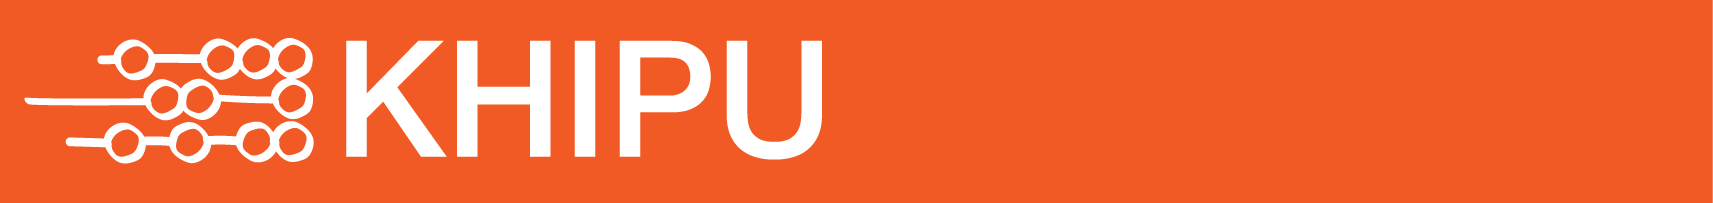